The scope of this project is to analyze MMA fight data in order to determine if there are any unusual forces that affect the outcomes of fights. 

Data has been gathered with web scraping scripts using PHP and Curl. Data was parsed and saved to text file. Data was loaded to SQL and scripts in repository used to clean and normalize the data. In SQL, Referee name was normalized, fight time was cleaned up and MethodClean was created to categorize the fight ending method.

Data load and feature creation below. IDMerge was created in order to be able to remove duplicate fight entries as stated in the next step. Stoppage, Decision, Month and Year created to more easily summarize data later on. WeightClass defined for fighters with an available weight in the data set.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file = 'fighterdata.txt'
df = pd.read_csv(file, delimiter='\t', encoding='latin-1').dropna(subset=['Result', 'Date'])
df['Date']=pd.to_datetime(df['Date'])
df['MethodClean'] = df['MethodClean'].astype('category')
df['IDMerge'] = df['FID'] + df['OID']
df['Stoppage'] = [1 if x in ['KO', 'Submission'] else 0 for x in df['MethodClean']]
df['Decision'] = [1 if x =='Decision' else 0 for x in df['MethodClean']]
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df['Year'] = df['Date'].dt.strftime('%Y')
df['WeightClass'] = ''
df.loc[(df['Weight']<90) | (df['Weight']>300), 'WeightClass'] = 'N/A'
df.loc[(df['Weight']<=105) & (df['Weight']>=90), 'WeightClass'] = '105'
df.loc[(df['Weight']<=115) & (df['Weight']>105), 'WeightClass'] = '115'
df.loc[(df['Weight']<=125) & (df['Weight']>115), 'WeightClass'] = '125'
df.loc[(df['Weight']<=135) & (df['Weight']>125), 'WeightClass'] = '135'
df.loc[(df['Weight']<=145) & (df['Weight']>135), 'WeightClass'] = '145'
df.loc[(df['Weight']<=155) & (df['Weight']>145), 'WeightClass'] = '155'
df.loc[(df['Weight']<=170) & (df['Weight']>155), 'WeightClass'] = '170'
df.loc[(df['Weight']<=185) & (df['Weight']>170), 'WeightClass'] = '185'
df.loc[(df['Weight']<=205) & (df['Weight']>185), 'WeightClass'] = '205'
df.loc[(df['Weight']<=300) & (df['Weight']>205), 'WeightClass'] = '265'
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592064 entries, 0 to 595915
Data columns (total 30 columns):
IDMerge          591875 non-null float64
FID              592064 non-null int64
FighterID        592064 non-null object
Fighter          592064 non-null object
FFights          0 non-null float64
Birthdate        591333 non-null object
Height           591333 non-null float64
Weight           592039 non-null float64
Result           592064 non-null object
OID              591875 non-null float64
OpponentID       591875 non-null object
Opponent         591875 non-null object
OFights          0 non-null float64
Method           586509 non-null object
EventID          591144 non-null object
Event            591875 non-null object
Date             592064 non-null datetime64[ns]
Round            591875 non-null float64
Time             571939 non-null object
Referee          261028 non-null object
RFights          231800 non-null float64
MethodClean      586487 non-null category
To

Full fight list contains records for both fighters. Below combines those into a single record for each fight using the previously created IDMerge.

In [22]:
uniquedf = df[['Referee', 'EventID', 'Event', 'IDMerge', 'Date', 'Round', 'Time', 'MethodClean', 'TotalTime', 'Stoppage', 'Decision', 'Month', 'Year']].dropna().drop_duplicates()
print(uniquedf.head())

            Referee                          EventID  \
0   Nasir Yousafzai  Flogger-Series-Contenders-83815   
2   Nasir Yousafzai  Flogger-Series-Contenders-83815   
34   Ryuichi Tanaka             Deep-Jewels-27-82581   
36   Ryuichi Tanaka             Deep-Jewels-27-82581   
38    Masato Fukuda             Deep-Jewels-27-82581   

                         Event   IDMerge       Date  Round  Time MethodClean  \
0   Flogger Series- Contenders  541584.0 2019-12-25    1.0  0:40          KO   
2   Flogger Series- Contenders  656608.0 2019-12-25    2.0  1:00  Submission   
34            Deep - Jewels 27  714148.0 2019-12-22    1.0  0:47  Submission   
36            Deep - Jewels 27  527164.0 2019-12-22    1.0  2:28  Submission   
38            Deep - Jewels 27  714124.0 2019-12-22    2.0  3:00    Decision   

    TotalTime  Stoppage  Decision    Month  Year  
0        0.67         1         0  2019-12  2019  
2        6.00         1         0  2019-12  2019  
34       0.78         1      

Data is summarized per referee to identify any outliers. Even among the referees who have overseen the most fights in MMA history, there is a fairly large range of rates of fight stoppage by the referees. Upon first glance, the referees most associated with the UFC, however, have fairly consistent stoppage rates. These include Herb Dean, John McCarthy, Dan Miragliotta, Marc Goddard, Keith Peterson and Jason Herzog, who all have stoppage rates of between 59 and 65%, while there are outliers in non-UFC referees such as Yoshinori Umeki at 49% and Mike England at 78%.

In [28]:
ref_summary = pd.pivot_table(uniquedf, index='Referee', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
ref_summary = ref_summary.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
ref_summary.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
ref_summary['StoppageRate'] = ref_summary['Stoppages'] / ref_summary['Fights']
print(ref_summary.sort_values(by='Fights', ascending=False).head(10))

                 Fights  Stoppages  Decisions   AvgTime  StoppageRate
Referee                                                              
Herb Dean          1625       1020        605  9.037877      0.627692
John McCarthy      1305        849        456  8.714406      0.650575
Dan Miragliotta    1208        770        438  8.687252      0.637417
Yoshinori Umeki    1099        544        555  9.821392      0.494995
Mike England       1078        850        228  6.291039      0.788497
Marc Goddard       1049        685        364  8.763642      0.653003
Keith Peterson     1007        595        412  9.191907      0.590864
Ashot Ashugyan      951        677        274  7.499190      0.711882
Jason Herzog        852        528        324  8.865035      0.619718
Kevin Nix           745        579        166  6.975128      0.777181


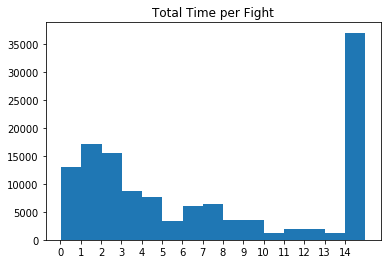

In [29]:
plt.hist(uniquedf.TotalTime, bins=15)
plt.title('Total Time per Fight')
plt.xticks(range(15))
plt.show()

The large bar at 15 minutes represents fights that go the distance and are subject to a judges decision and is the largest single bucket by far. The rest of the buckets indicate a few different things:

1. The chart shows that a fight is more likely to end in a KO or submission earlier in the fight when the fighters are fresher. As the fight wears on they get more and more tired, punches don't land quite as hard, there is less strength available to put into submission attempts and, as the fight goes on, the fighters sweat more and more and submission holds that rely on friction to secure become tougher and tougher to complete.
2. With five minute rounds standard, you can see a slight dip in the first minute of each of the three rounds before the finish rate increases before tapering off towards the end of each round. This makes sense as the beginning of each round generally involves the fighters touching gloves as a sign of respect before the fighters dig in. Additionally, there is usually a bit of a feeling out process to start each round before the fighters begin to increase output and attempt to gain an advantage and attempt to finish the fight.

Data is now summarized per year to identify trends over time. 

In [30]:
finish_history = pd.pivot_table(uniquedf, index='Year', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
finish_history = finish_history.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
finish_history.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
finish_history = finish_history.dropna()
finish_history['StoppageRate'] = finish_history['Stoppages'] / finish_history['Fights']
print(finish_history)

      Fights  Stoppages  Decisions   AvgTime  StoppageRate
Year                                                      
1993      28         28          0  3.711786      1.000000
1994      48         45          3  4.846667      0.937500
1995     143        117         26  6.087483      0.818182
1996     141         95         46  8.318156      0.673759
1997     195        149         46  6.710205      0.764103
1998     160         95         65  9.308875      0.593750
1999     286        198         88  7.892098      0.692308
2000     206        128         78  8.494709      0.621359
2001     198        151         47  6.702626      0.762626
2002     309        201        108  8.133236      0.650485
2003     329        211        118  8.304863      0.641337
2004     588        394        194  7.546548      0.670068
2005     690        525        165  6.670290      0.760870
2006    1031        784        247  6.608807      0.760427
2007    1691       1307        384  6.383596      0.7729

Average fight time and total fights per year plotted. What can be learned from the distribution over time?

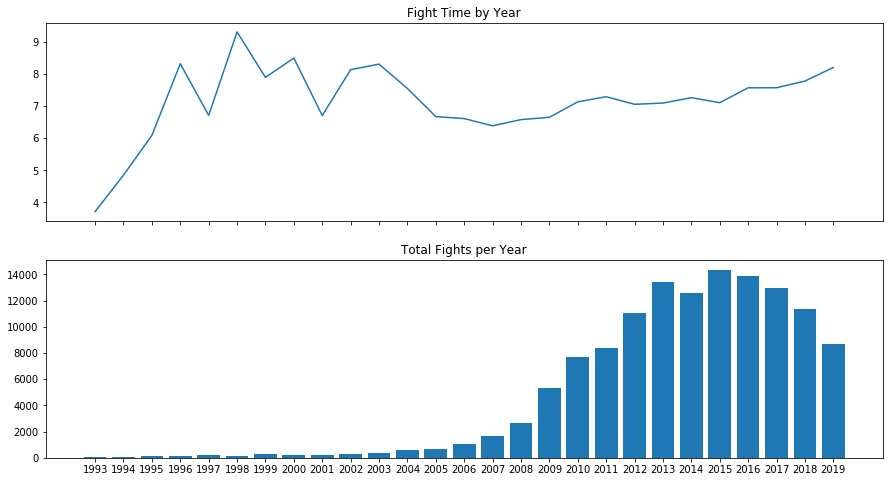

In [31]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

ax[0].plot(finish_history.AvgTime)
ax[0].title.set_text('Fight Time by Year')

ax[1].bar(finish_history.index, finish_history.Fights)
ax[1].title.set_text('Total Fights per Year')

plt.show()

In the early days of Mixed Martial Arts, it was a bit of a wild west when it came to rules and regulations. The early UFC events, for example, had no weight classes, rounds or judges. No fights went to a decision and other than biting and eye gouging, there were no more rules. As the popularity increased, more organizations were promoting events and there were no standard rules. This volatility of the sport in the early days can be seen in the inconsistency of the average fight time before any standards were established.

In 2000, the California State Athletic Commission approved a set of standard rules for the sport and in 2001, the New Jersey State Athletic Control Board finalized the Unified Rules of Mixed Martial Arts along with other regulatory bodies, promotions and experts of the sport. Fairly shortly after this, all athletic commissions in the United States regulating the sport would adopt these rules. From the chart above, you can see the volatility of the early history even out after the Unified Rules were instituted.

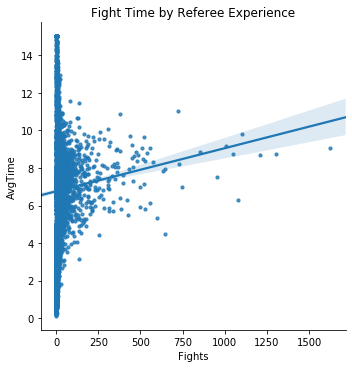

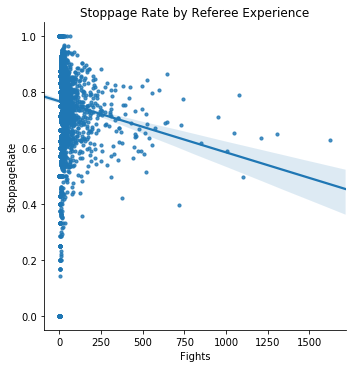

In [32]:
sns.lmplot(x='Fights', y='AvgTime', data=ref_summary, scatter_kws={"s": 10})
plt.title('Fight Time by Referee Experience')
plt.show()
sns.lmplot(x='Fights', y='StoppageRate', data=ref_summary, scatter_kws={"s": 10})
plt.title('Stoppage Rate by Referee Experience')
plt.show()

Here, both the average fight times and the stoppage rates for fights overseen by each referee is plotted against the total fights by the referee. While the range does continue to vary quite a bit, even after hundreds of fights, there is a solid trend in both charts which is consistent. The average fight time per referee goes up over time at a similar slope that the fight stoppage rate decreases. This could indicate that as referees are more experienced, they are better equipped at assessing how much danger a fighter might be in and are less prone to jump in and stop a fight early. The other posibility is that as a referee gains more experience they may get bigger opportunities to referee in larger organizations with fights more equally matched and therefore the lower stoppage rates are less a result of the referee experience.

Time to plot the stoppage rate in the same manner as the average fight time was earlier over time.

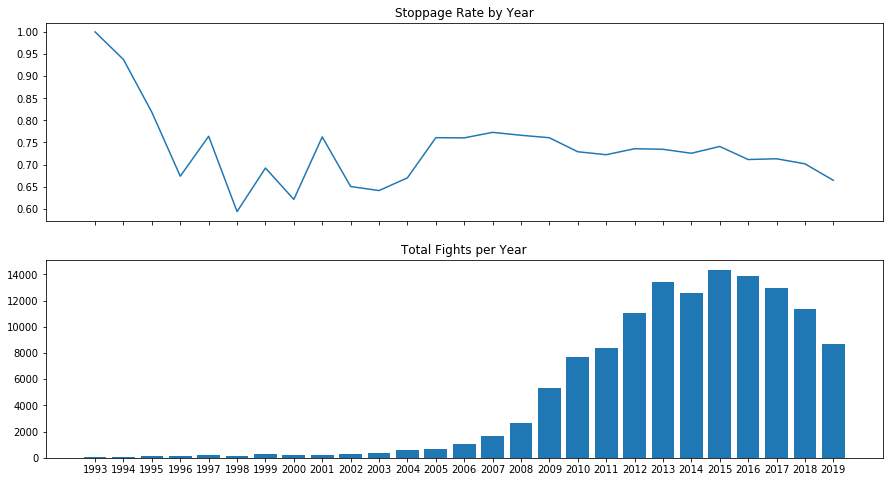

In [33]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

ax[0].plot(finish_history.StoppageRate)
ax[0].title.set_text('Stoppage Rate by Year')

ax[1].bar(finish_history.index, finish_history.Fights)
ax[1].title.set_text('Total Fights per Year')

plt.show()

The line chart for the stoppage rate is almost a direct inverse of the average time chart. While I expected it to correlate somewhat with the average time chart, this much similarity is a bit of a surprise.

Next I want to focus back on the scatter plots and to see if there is any reason for the outliers when it comes to stoppage rates. First, let's look at experienced referees with unusually low stoppage rates.

In [34]:
print(ref_summary[(ref_summary.Fights>100) & (ref_summary.StoppageRate<0.55)])

                   Fights  Stoppages  Decisions    AvgTime  StoppageRate
Referee                                                                 
Andres Manzanares     132         66         66  10.677576      0.500000
Chris Tognoni         285        154        131   9.531474      0.540351
Hirokazu Takamoto     165         85         80   9.801212      0.515152
Hirotoshi Okamoto     137         66         71  10.192409      0.481752
Junichi Ota           123         54         69  10.673496      0.439024
Kenichi Serizawa      523        269        254   9.665239      0.514340
Kenji Kosuge          377        159        218  10.869257      0.421751
Masato Fukuda         308        153        155  10.065974      0.496753
Samio Kimura          174         93         81   9.456149      0.534483
Taro Wakabayashi      134         48         86  11.434478      0.358209
Tomoki Matsumiya      222        121        101   9.414459      0.545045
Toshiharu Suzuki      721        287        434  11

First running the report filtering for referees with more than 100 fights and a stoppage rate under 50%, returns seven referees. All of these referees are Japanese. Increasing the rate to 55% expands the list to 14 referees, with 12 of them being Japanese, also returning the first UFC referee, Chris Tognoni.

A couple of explanations come to mind for the disproportionately large representation of Japanese referees in fights with lower stoppage rates:

1. Japan and Japanese promotions are not governed by the Unified Rules of Mixed Martial Arts and therefore events in Japan do have more fights that span just two rounds rather than the standard three in most of the world. This could have some impact, although with the earlier analysis that showed that the finish rates are greatly decreased in the third round, the disparity seems too large for that to be the only explanation.
2. While this is difficult to show with this dataset and would require additional data collection to show in its entirety, in my experience I have witnessed that Japanese fighters typically occupy lower weight classes which typically have lower stoppage rates than higher weight classes.

While I cannot tie the weight of fighters to a particular country of origin in this data set, I can test the hypothesis that stoppage rates increase as the weight of the fighters increases. I'll test that below.

             Fights  Stoppages  Decisions   AvgTime  StoppageRate
WeightClass                                                      
105            1497        796        687  9.906612      0.531730
115            9313       5484       3689  9.247783      0.588854
125           32837      21107      11219  8.415907      0.642781
135           59477      40119      18529  8.020716      0.674530
145           80830      56204      23463  7.721207      0.695336
155           94532      67592      25466  7.482400      0.715017
170           93000      68714      22766  7.233043      0.738860
185           61283      47028      13168  6.797538      0.767391
205           38560      30615       7118  6.381712      0.793957
265           34714      28089       5745  5.986291      0.809155


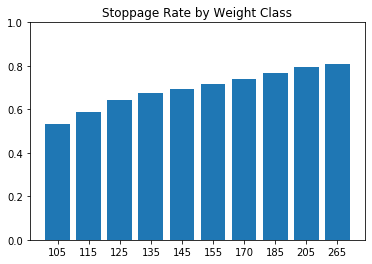

In [35]:
weightdf = pd.pivot_table(df[(df['WeightClass'] > '100') & (df['WeightClass'] != 'N/A')], index='WeightClass', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
weightdf = weightdf.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
weightdf.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
weightdf = weightdf.dropna()
weightdf['StoppageRate'] = weightdf['Stoppages'] / weightdf['Fights']
#dropdf = weightdf[(weightdf['WeightClass'] < 100) | (weightdf['WeightClass'] == 'N/A')]
#wdf_summary = pd.pivot_table(weightdf, index='Weight', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
#wdf_summary = wdf_summary.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
#wdf_summary.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
#wdf_summary['StoppageRate'] = wdf_summary['Stoppages'] / wdf_summary['Fights']
#plt.hist(wdf_summary.StoppageRate, bins=16)
#plt.title('Stoppage Rate per Weight')
#plt.show()
#plt.hist(uniquedf.TotalTime, bins=16)
#plt.title('Total Time per Fight')
#plt.xticks(range(16))
#plt.show()
#print(dropdf)
print(weightdf)
plt.bar(weightdf.index, weightdf.StoppageRate)
plt.yticks((0.0,0.2,0.4,0.6,0.8,1.0))
plt.title('Stoppage Rate by Weight Class')
plt.show()

As suspected, the stoppage rates do consistently increase as the size of the fighters increases. While the stoppage rate for 105 lb fighters is barely north of 50% at 53%, the stoppage rate for heavyweight fighers more than 205 lbs is all the way up at 80%.

Next I want to look at the outliers on the higher end of the stoppage rates which may indicate referees that are more likely to stop a fight early and thus a fighter going into a fight refereed by one of them may want to ensure the referee is clear when they are still fighting intelligently in order to prevent an early stoppage.

In [36]:
print(ref_summary[(ref_summary.Fights>100) & (ref_summary.StoppageRate>0.85)].sort_values(by=['StoppageRate'], ascending=False))

                    Fights  Stoppages  Decisions   AvgTime  StoppageRate
Referee                                                                 
Shorty Williams        107        100          7  4.075701      0.934579
Pino Barber            136        123         13  4.657353      0.904412
Franklin Aguirre       135        122         13  3.144815      0.903704
Dan Grimestad          158        142         16  5.072848      0.898734
Andreas Stockmann      146        130         16  4.524521      0.890411
Jan Hudak              115        102         13  5.553826      0.886957
Henryk Kretzschmar     106         94         12  4.357925      0.886792
Ryan Thorpe            252        223         29  4.420397      0.884921
Rusty Sullivan         179        158         21  4.925531      0.882682
David Wald             178        157         21  5.261685      0.882022
Jerome Locke           134        118         16  4.900373      0.880597
Jarid Symens           133        117         16  5

In [37]:
refereeweight = pd.pivot_table(df[(df['WeightClass'] > '100') & (df['WeightClass'] != 'N/A')], index='Referee', values=['TotalTime', 'Stoppage', 'Decision', 'Weight'], aggfunc=[len, np.mean, np.sum])
refereeweight = refereeweight.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','Weight')]]
refereeweight.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgWeight')
refereeweight = refereeweight.loc[:, ['AvgWeight']]
print(refereeweight.sort_values(by=['AvgWeight'], ascending=False).head(10))

                   AvgWeight
Referee                     
Ross Upton        280.000000
Vagelis moumtzis  265.000000
Celso Ricardo     265.000000
Golovkov Bogdan   265.000000
TJ De Santis      263.333333
Rafae Lasota      263.000000
Rob Stanick       258.500000
Davut Sidal       254.500000
Marko Miklavc     253.500000
Frank Telle       252.500000


In [38]:
ref_summary_plus = pd.concat([ref_summary, refereeweight], axis=1, sort=True).sort_values(by=['StoppageRate'], ascending=False)
ref_summary_plus = ref_summary_plus[(ref_summary_plus.Fights>25)]
print(ref_summary_plus.head())
ref_summary_plus.to_csv('ref_summary_plus.csv')

               Fights  Stoppages  Decisions   AvgTime  StoppageRate  \
John Perretti    45.0       45.0        0.0  2.857333           1.0   
Jorge Pereira    64.0       64.0        0.0  3.523906           1.0   
Uvais Bisayev    27.0       27.0        0.0  3.101852           1.0   
Dejan Djuric     27.0       27.0        0.0  1.818148           1.0   
Adela Sakul      34.0       34.0        0.0  3.683529           1.0   

                AvgWeight  
John Perretti  192.696629  
Jorge Pereira  170.330645  
Uvais Bisayev  166.106383  
Dejan Djuric   188.860000  
Adela Sakul    155.680851  


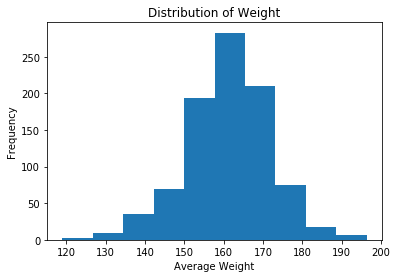

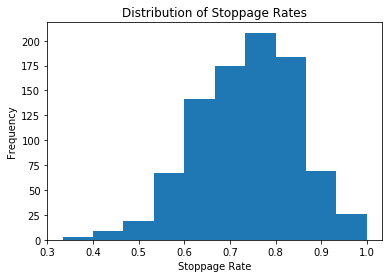

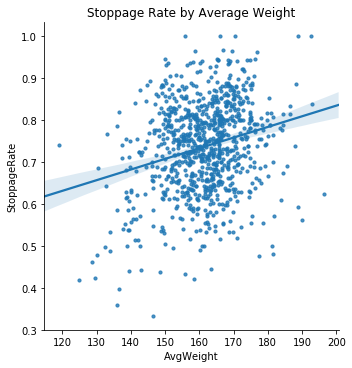

In [40]:
plt.hist(ref_summary_plus['AvgWeight'], bins=10)
plt.title('Distribution of Weight')
plt.xlabel('Average Weight')
plt.ylabel('Frequency')
plt.show()

plt.hist(ref_summary_plus['StoppageRate'], bins=10)
plt.title('Distribution of Stoppage Rates')
plt.xlabel('Stoppage Rate')
plt.ylabel('Frequency');
plt.show()

sns.lmplot(x='AvgWeight', y='StoppageRate', data=ref_summary_plus, scatter_kws={"s": 10})
plt.title('Stoppage Rate by Average Weight')
plt.show()

Well, while there is slight correlation between the stoppage rate and average weight per referee overall, there are far too many outliers to explain high stoppage rates of some referees on overseeing a higher percentage of fights with larger fighters. Perhaps there is more skewing the data here.

Will look to removing fights from before the Unified Rules were instituted to see if that has any effect.

In [41]:
df_modern = df[df['Year'] >= '2002']
uniquedf_modern = df_modern[['Referee', 'EventID', 'Event', 'IDMerge', 'Date', 'Round', 'Time', 'MethodClean', 'TotalTime', 'Stoppage', 'Decision', 'Month', 'Year']].dropna().drop_duplicates()
ref_summary_modern = pd.pivot_table(uniquedf_modern, index='Referee', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
ref_summary_modern = ref_summary_modern.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
ref_summary_modern.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
ref_summary_modern['StoppageRate'] = ref_summary_modern['Stoppages'] / ref_summary_modern['Fights']
print(ref_summary_modern.sort_values(by='Fights', ascending=False).head(10))

refweight_modern = pd.pivot_table(df_modern[(df_modern['WeightClass'] > '100') & (df_modern['WeightClass'] != 'N/A')], index='Referee', values=['TotalTime', 'Stoppage', 'Decision', 'Weight'], aggfunc=[len, np.mean, np.sum])
refweight_modern = refweight_modern.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','Weight')]]
refweight_modern.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgWeight')
refweight_modern = refweight_modern.loc[:, ['AvgWeight']]
print(refweight_modern.sort_values(by=['AvgWeight'], ascending=False).head(10))

ref_modern_plus = pd.concat([ref_summary_modern, refweight_modern], axis=1, sort=True).sort_values(by=['StoppageRate'], ascending=False)
ref_modern_plus = ref_modern_plus[(ref_modern_plus.Fights>100)]
print(ref_modern_plus.head())
ref_modern_plus.to_csv('ref_modern_plus.csv')

                 Fights  Stoppages  Decisions   AvgTime  StoppageRate
Referee                                                              
Herb Dean          1615       1012        603  9.057269      0.626625
Dan Miragliotta    1208        770        438  8.687252      0.637417
Mike England       1078        850        228  6.291039      0.788497
John McCarthy      1052        647        405  9.240114      0.615019
Marc Goddard       1049        685        364  8.763642      0.653003
Keith Peterson     1007        595        412  9.191907      0.590864
Yoshinori Umeki     957        467        490  9.905653      0.487983
Ashot Ashugyan      951        677        274  7.499190      0.711882
Jason Herzog        852        528        324  8.865035      0.619718
Kevin Nix           745        579        166  6.975128      0.777181
                   AvgWeight
Referee                     
Ross Upton        280.000000
Vagelis moumtzis  265.000000
Golovkov Bogdan   265.000000
Celso Ricardo  

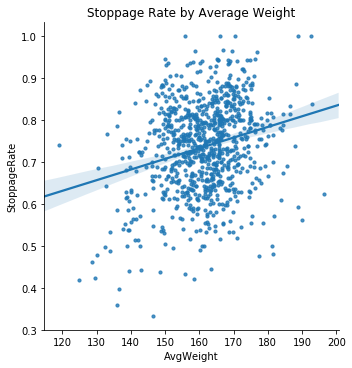

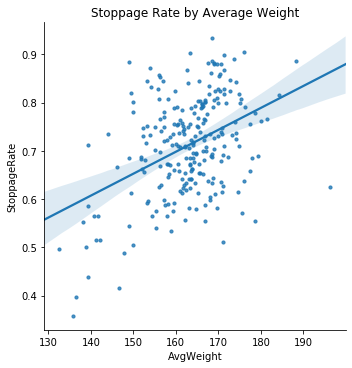

In [43]:
sns.lmplot(x='AvgWeight', y='StoppageRate', data=ref_summary_plus, scatter_kws={"s": 10})
plt.title('Stoppage Rate by Average Weight')
plt.show()

sns.lmplot(x='AvgWeight', y='StoppageRate', data=ref_modern_plus, scatter_kws={"s": 10})
plt.title('Stoppage Rate by Average Weight')
plt.show()

That has only minimal effect.

In [44]:
print(df[df['Referee'] == 'Shorty Williams']['EventID'].drop_duplicates())

191086    SAARFC-8-Solid-as-a-Rock-Fighting-Championship...
232559    SAARFC-5-Solid-as-a-Rock-Fighting-Championship...
242067    SAARFC-4-Solid-as-a-Rock-Fighting-Championship...
256556    SAARFC-3-Solid-as-a-Rock-Fighting-Championship...
285631    SAARFC-1-Solid-as-a-Rock-Fighting-Championship...
300120              Midnight-Sun-Mayhem-2-Fight-Night-23157
311205                       ACF-Alaska-Cage-Fighting-18863
317687                       ACF-Alaska-Cage-Fighting-18862
324912                       ACF-Alaska-Cage-Fighting-18861
329163                        ACF-Tribute-to-Veterans-18837
337852                       ACF-Alaska-Cage-Fighting-18215
344167                                ACF-Strike-Fest-17281
349798                       ACF-Alaska-Cage-Fighting-16649
354511                       ACF-Alaska-Cage-Fighting-16630
359459                       ACF-Alaska-Cage-Fighting-16131
406467                                 CR-Cage-Rage-7-18371
Name: EventID, dtype: object


The referee with the highest stoppage rate is Shorty Williams. Most of the events he refereed at were for Alaska Cage Fighting.

In [45]:
print(df[df['EventID'].str.contains('Alaska', na=False)][['Referee','Stoppage','Decision']].groupby('Referee').sum())

                  Stoppage  Decision
Referee                             
Al Medina               19         0
Anthony Manacio         25         8
Damien Horvath          14         0
Henry Dehling            4         2
Jarid Symens             3         0
Jonathan Morford         8         2
Michael Engel           14         0
Paul Stockler           14         0
Pino Barber             21         2
Russ Stevens            50        11
Shorty Williams        102         4


In looking at all of the referees that have officiated fights in the organization, almost all of them also have extremely high stoppage rates as well. Perhaps smaller events and more inexperienced fighters are the cause of the high rates.

In [61]:
ufcdf = df[(df['EventID'].str.startswith('UFC-', na=False)) & (df['Year'] >= '2004')]
print(ufcdf.head())

ufcuniquedf = ufcdf[['Referee', 'EventID', 'Event', 'IDMerge', 'Date', 'Round', 'Time', 'MethodClean', 'TotalTime', 'Stoppage', 'Decision', 'Month', 'Year']].dropna().drop_duplicates()
print(ufcuniquedf.head())

ufcrefsummary = pd.pivot_table(ufcuniquedf, index='Referee', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
ufcrefsummary = ufcrefsummary.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
ufcrefsummary.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
ufcrefsummary['StoppageRate'] = ufcrefsummary['Stoppages'] / ufcrefsummary['Fights']
print(ufcrefsummary.sort_values(by='Fights', ascending=False).head(10))

ufcrefweight = pd.pivot_table(ufcdf[(ufcdf['WeightClass'] > '100') & (ufcdf['WeightClass'] != 'N/A')], index='Referee', values=['TotalTime', 'Stoppage', 'Decision', 'Weight'], aggfunc=[len, np.mean, np.sum])
ufcrefweight = ufcrefweight.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','Weight')]]
ufcrefweight.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgWeight')
ufcrefweight = ufcrefweight.loc[:, ['AvgWeight']]
print(ufcrefweight.sort_values(by=['AvgWeight'], ascending=False).head(10))

ufcrefsummary_plus = pd.concat([ufcrefsummary, ufcrefweight], axis=1, sort=True).sort_values(by=['StoppageRate'], ascending=False)
ufcrefsummary_plus = ufcrefsummary_plus[(ufcrefsummary_plus.Fights>30)]
print(ufcrefsummary_plus.head())
ufcrefsummary_plus.to_csv('ufcrefsummary_plus.csv')

      IDMerge     FID              FighterID         Fighter  FFights  \
163  310132.0  107891  Mike-Rodriguez-107891  Mike Rodriguez      NaN   
164  310132.0  202241      Da-Un-Jung-202241      Da Un Jung      NaN   
165   50359.0   14204    Frankie-Edgar-14204   Frankie Edgar      NaN   
166   50359.0   36155   Chan-Sung-Jung-36155  Chan Sung Jung      NaN   
167  425014.0  173973    Amanda-Lemos-173973    Amanda Lemos      NaN   

           Birthdate  Height  Weight Result       OID  ... RFights  \
163  11/28/1988 0:00    75.0   205.0   loss  202241.0  ...     NaN   
164   2/11/1988 0:00    75.0   205.0    win  107891.0  ...     NaN   
165  10/16/1981 0:00    66.0   145.0   loss   36155.0  ...     NaN   
166   3/17/1987 0:00    69.0   145.0    win   14204.0  ...     NaN   
167   5/22/1987 0:00    64.0   135.0    win  251041.0  ...     NaN   

    MethodClean  TotalTime AdjustedRound AdjustedTime Stoppage Decision  \
163          KO       1.07           1.0         1:04        1   

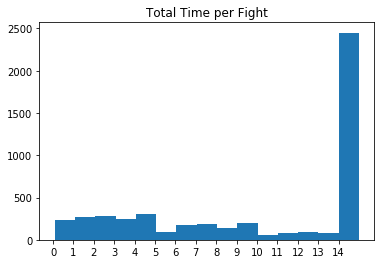

In [47]:
plt.hist(ufcuniquedf.TotalTime, bins=15)
plt.title('Total Time per Fight')
plt.xticks(range(15))
plt.show()

In [48]:
ufcfinish_history = pd.pivot_table(ufcuniquedf, index='Year', values=['TotalTime', 'Stoppage', 'Decision'], aggfunc=[len, np.mean, np.sum])
ufcfinish_history = ufcfinish_history.loc[:, [('len', 'Decision'), ('sum','Stoppage'), ('sum','Decision'), ('mean','TotalTime')]]
ufcfinish_history.columns = ('Fights', 'Stoppages', 'Decisions', 'AvgTime')
ufcfinish_history = ufcfinish_history.dropna()
ufcfinish_history['StoppageRate'] = ufcfinish_history['Stoppages'] / ufcfinish_history['Fights']
print(ufcfinish_history)

      Fights  Stoppages  Decisions    AvgTime  StoppageRate
Year                                                       
2004      25         20          5   7.599200      0.800000
2005      50         37         13   8.021400      0.740000
2006      97         67         30   8.400206      0.690722
2007     169        107         62   8.981124      0.633136
2008     201        137         64   8.571244      0.681592
2009     217        129         88   9.368756      0.594470
2010     248        127        121  10.572903      0.512097
2011     296        150        146  10.232432      0.506757
2012     332        174        158   9.974970      0.524096
2013     376        197        179  10.161090      0.523936
2014     494        247        247  10.505304      0.500000
2015     464        243        221  10.369397      0.523707
2016     490        242        248  10.755408      0.493878
2017     450        226        224  10.715867      0.502222
2018     468        241        227  10.6

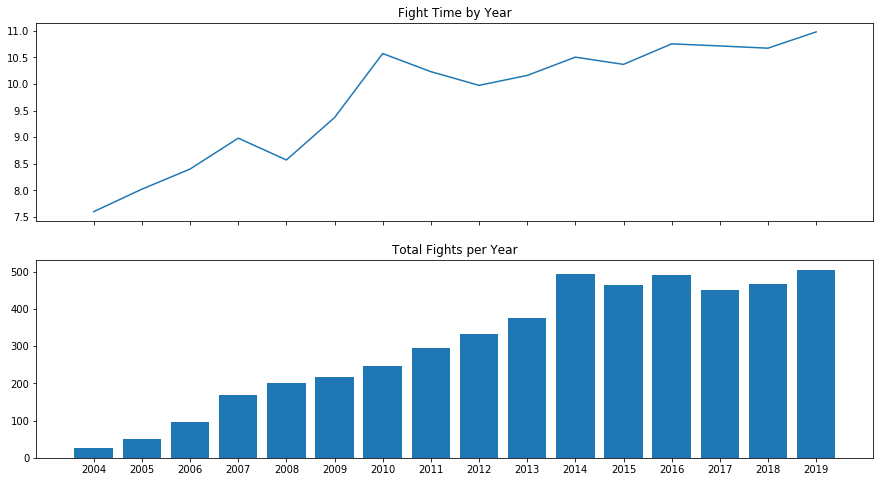

In [49]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

ax[0].plot(ufcfinish_history.AvgTime)
ax[0].title.set_text('Fight Time by Year')

ax[1].bar(ufcfinish_history.index, ufcfinish_history.Fights)
ax[1].title.set_text('Total Fights per Year')

plt.show()

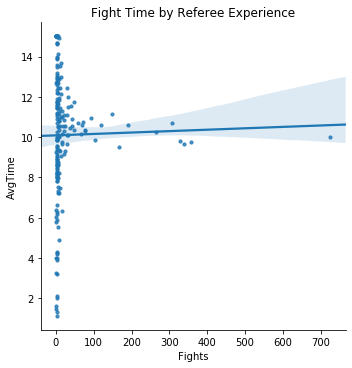

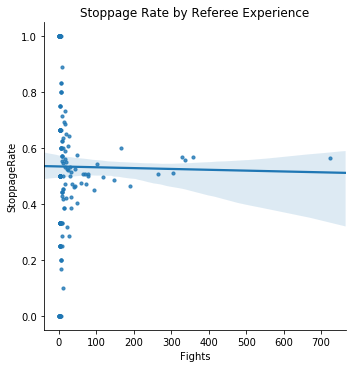

In [50]:
sns.lmplot(x='Fights', y='AvgTime', data=ufcrefsummary, scatter_kws={"s": 10})
plt.title('Fight Time by Referee Experience')
plt.show()
sns.lmplot(x='Fights', y='StoppageRate', data=ufcrefsummary, scatter_kws={"s": 10})
plt.title('Stoppage Rate by Referee Experience')
plt.show()

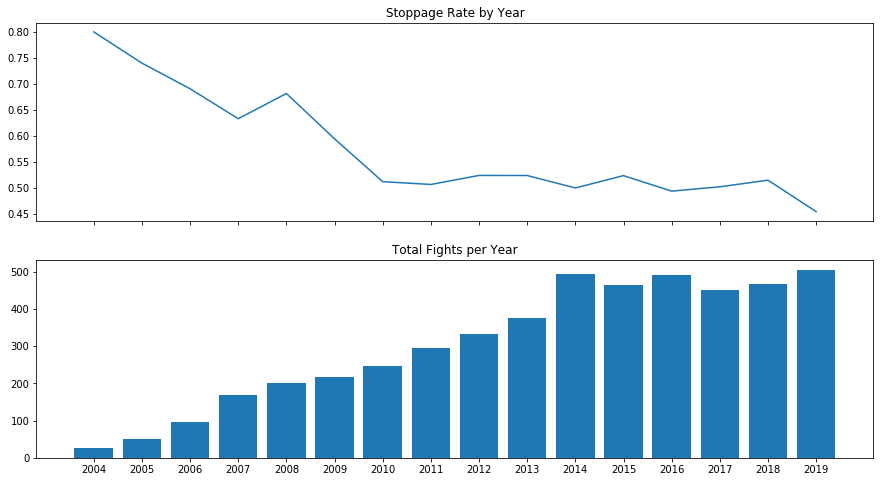

In [51]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

ax[0].plot(ufcfinish_history.StoppageRate)
ax[0].title.set_text('Stoppage Rate by Year')

ax[1].bar(ufcfinish_history.index, ufcfinish_history.Fights)
ax[1].title.set_text('Total Fights per Year')

plt.show()

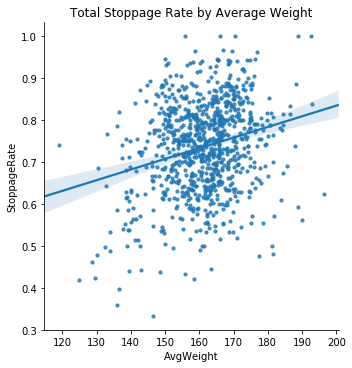

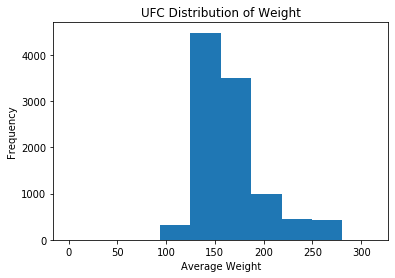

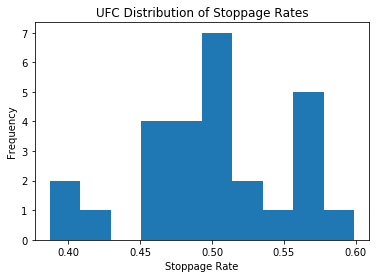

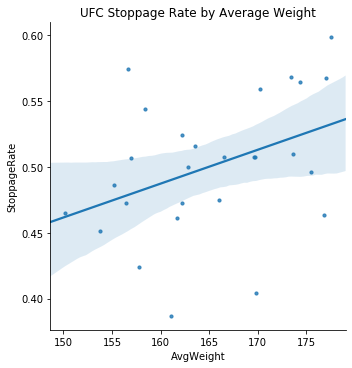

In [63]:
sns.lmplot(x='AvgWeight', y='StoppageRate', data=ref_summary_plus, scatter_kws={"s": 10})
plt.title('Total Stoppage Rate by Average Weight')
plt.show()

plt.hist(ufcdf['Weight'], bins=10)
plt.title('UFC Distribution of Weight')
plt.xlabel('Average Weight')
plt.ylabel('Frequency')
plt.show()

plt.hist(ufcrefsummary_plus['StoppageRate'], bins=10)
plt.title('UFC Distribution of Stoppage Rates')
plt.xlabel('Stoppage Rate')
plt.ylabel('Frequency');
plt.show()

sns.lmplot(x='AvgWeight', y='StoppageRate', data=ufcrefsummary_plus, scatter_kws={"s": 10})
plt.title('UFC Stoppage Rate by Average Weight')
plt.show()

In [62]:
print(ufcrefsummary_plus[(ufcrefsummary_plus.Fights>30) & (ufcrefsummary_plus.StoppageRate<0.55)])

                 Fights  Stoppages  Decisions    AvgTime  StoppageRate  \
Referee                                                                  
Jason Herzog        103         56         47   9.871748      0.543689   
Kim Winslow          42         22         20  10.875714      0.523810   
Gary Copeland        31         16         15  10.093871      0.516129   
Marc Goddard        306        156        150  10.709771      0.509804   
Mark Smith           65         33         32  10.144615      0.507692   
Yves Lavigne        264        134        130  10.255076      0.507576   
John Sharp           69         35         34  10.618261      0.507246   
Kevin MacDonald      77         39         38  10.328571      0.506494   
Steve Perceval       78         39         39  10.315897      0.500000   
Josh Rosenthal      119         59         60  10.624286      0.495798   
Keith Peterson      148         72         76  11.152770      0.486486   
Kevin Mulhall        59         28    